In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [20]:
file_path = "sireNNet/espectrogramas_sirennet/sirennet_espectrograma.csv"
df = pd.read_csv(file_path)
df.head()

,class,name,path,spectrogram_path
0,ambulance,sound_1.wav,../datasets/sireNNet\ambulance\sound_1.wav,./sireNNet/espectrogramas_sirennet\ambulance\s...
1,ambulance,sound_10.wav,../datasets/sireNNet\ambulance\sound_10.wav,./sireNNet/espectrogramas_sirennet\ambulance\s...
2,ambulance,sound_100.wav,../datasets/sireNNet\ambulance\sound_100.wav,./sireNNet/espectrogramas_sirennet\ambulance\s...
3,ambulance,sound_100_1.wav,../datasets/sireNNet\ambulance\sound_100_1.wav,./sireNNet/espectrogramas_sirennet\ambulance\s...
4,ambulance,sound_101.wav,../datasets/sireNNet\ambulance\sound_101.wav,./sireNNet/espectrogramas_sirennet\ambulance\s...


In [49]:
# Ver porcentaje de cada clase
porcentajes = df['class'].value_counts(normalize=True) * 100

# Mostrar redondeado
print(porcentajes.round(2))


class
police       36.2
ambulance    31.9
firetruck    31.9
Name: proportion, dtype: float64


In [ ]:
df['spectrogram_path'] = df['spectrogram_path'].apply(lambda x: x.replace("\\", "/"))
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['class'])

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

IMG_SIZE = (370, 370)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

def load_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0 
    return image, label

def create_dataset(df):
    paths = df['spectrogram_path'].values
    labels = df['label'].values
    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
    dataset = dataset.map(load_image, num_parallel_calls=AUTOTUNE)
    return dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

train_ds = create_dataset(train_df)
val_ds = create_dataset(val_df)


In [22]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=(370, 370, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(label_encoder.classes_), activation='softmax')
])



In [23]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_ds, validation_data=val_ds, epochs=10)


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.3913 - loss: 2.7159 - val_accuracy: 0.6534 - val_loss: 0.8359
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.6875 - loss: 0.7469 - val_accuracy: 0.8247 - val_loss: 0.4519
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.7830 - loss: 0.5057 - val_accuracy: 0.8287 - val_loss: 0.4680
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.8253 - loss: 0.4817 - val_accuracy: 0.8725 - val_loss: 0.3645
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.8768 - loss: 0.3460 - val_accuracy: 0.9004 - val_loss: 0.2987
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.8898 - loss: 0.2860 - val_accuracy: 0.8845 - val_loss: 0.3246
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.8986 - loss: 0.2780 - val_accuracy: 0.9004 - val_loss: 0.2833
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.9354 - loss: 0.2132 - val_accuracy: 0.9243 - val_loss:

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

print(f"Training Accuracy: {acc[-1]}")
print(f"Validation Accuracy: {val_acc[-1]}")


Training Accuracy: 0.9531405568122864
Validation Accuracy: 0.9322709441184998


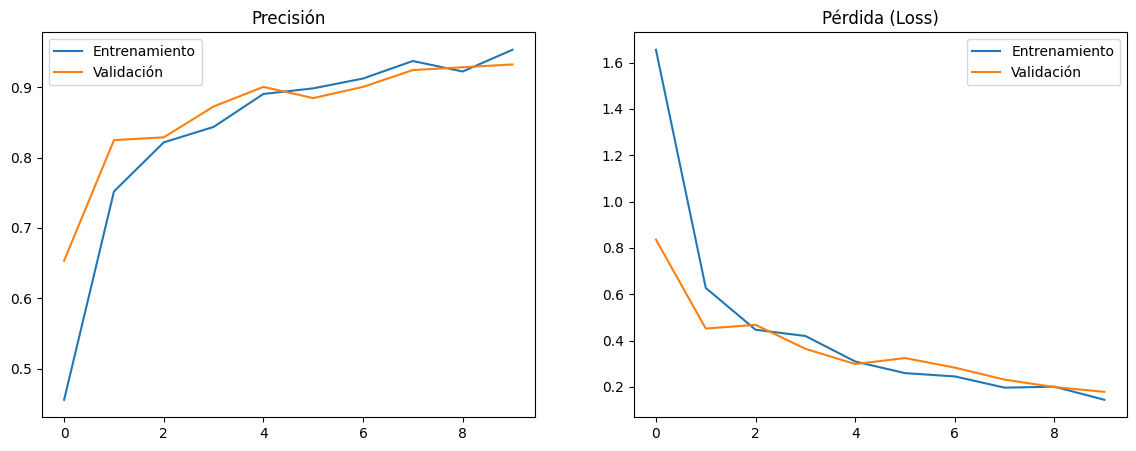

In [ ]:
import matplotlib.pyplot as plt

def plot_historia_entrenamiento(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Entrenamiento')
    plt.plot(epochs_range, val_acc, label='Validación')
    plt.title('Precisión')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Entrenamiento')
    plt.plot(epochs_range, val_loss, label='Validación')
    plt.title('Pérdida (Loss)')
    plt.legend()

    plt.show()


plot_historia_entrenamiento(history)


In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from io import BytesIO
from PIL import Image

def wav_a_tensor(wav_path, target_size=(370, 370)):
    # Cargar audio
    y, sr = librosa.load(wav_path, sr=None)

    # Crear espectrograma Mel
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    S_dB = librosa.power_to_db(S, ref=np.max)

    # Dibujar el espectrograma en memoria
    fig = plt.figure(figsize=(4, 4), dpi=100)  # esto genera 400x400 pero luego redimensionamos
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    librosa.display.specshow(S_dB, sr=sr, cmap='magma')

    # Guardar en buffer en memoria
    buf = BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
    plt.close(fig)
    buf.seek(0)

    # Convertir imagen desde el buffer
    image = Image.open(buf).convert('RGB')
    image = image.resize(target_size)
    image = np.array(image).astype(np.float32) / 255.0
    image_tensor = tf.expand_dims(image, axis=0)

    return image_tensor


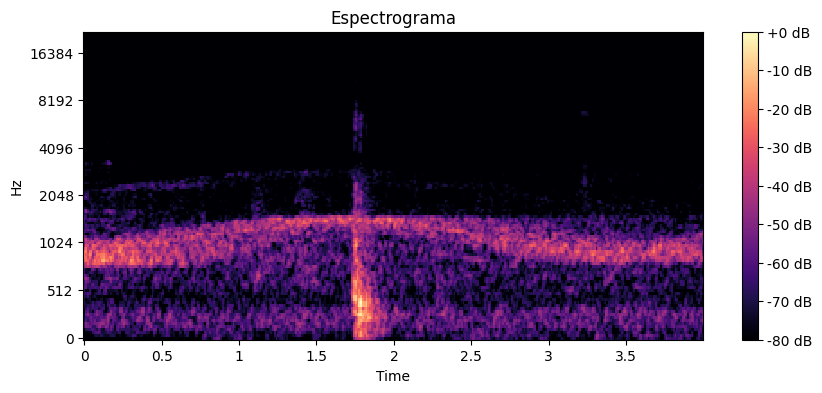

In [44]:
audio_predict_path = "datasets/UrbanSound8K/fold7/102853-8-0-2.wav"

y, sr = librosa.load(audio_predict_path, sr=44100)
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
S_db = librosa.amplitude_to_db(S, ref=np.max)

# Mostrar espectrograma
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title("Espectrograma")
plt.show()

In [45]:
image_tensor = wav_a_tensor(audio_predict_path)
print(image_tensor.shape)

(1, 370, 370, 3)


In [46]:
pred = model.predict(image_tensor)
pred_clase = np.argmax(pred, axis=1)[0]
etiqueta = label_encoder.inverse_transform([pred_clase])[0]

print(f"Predicción: {etiqueta}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Predicción: ambulance


<Figure size 800x600 with 0 Axes>

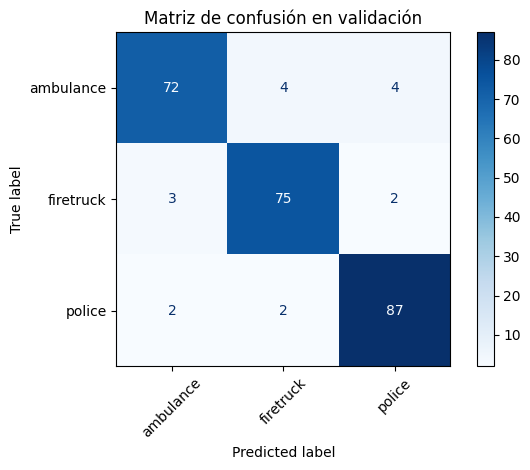

In [48]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Listas para etiquetas reales y predichas
y_true = []
y_pred = []

# Iterar sobre el conjunto de validación
for images, labels in val_ds.unbatch().take(1000):
    preds = model.predict(tf.expand_dims(images, axis=0), verbose=0)
    pred_label = np.argmax(preds)
    y_true.append(labels.numpy())
    y_pred.append(pred_label)

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Matriz de confusión en validación")
plt.tight_layout()
plt.show()
